In [1]:
using Pipe
using DataFrames
# using StatsPlots
using CSV
# using RollingFunctions
using Query
# using GLMakie

using JSON
using DataFrames
using Dates
using Colors
# using ColorSchemes
using Indicators

import Colors
using Plots
using Interact
using Statistics
using StatsBase

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-16849360041610248599\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-6622906690287581251\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-16849360041610248599\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [63]:
json_data_folder = "../user_data/data/binance"
json_filename = "BTC_USDT-1m.json"
json_filepath = "$json_data_folder/$json_filename"
f = open(json_filepath, "r")
json_data = JSON.parse(f)
close(f)

dfa = DataFrame(unix_time = Int64[], open=Float64[], high=Float64[], low=Float64[], close=Float64[], volume=Float64[])
for r in json_data push!(dfa, r) end
dfa.unix_time .= dfa.unix_time ./1000
# dfa.time .= unix2datetime.(dfa.unix_time)

insertcols!(dfa, :time => unix2datetime.(dfa.unix_time))
nrow(dfa)

129177

In [64]:
start_date = DateTime(2021, 1, 1)
end_date = DateTime(2021, 5, 7)
vdf = dfa[(dfa.time .>= start_date) .& (dfa.time .<= end_date) , :]
ut, tt, hh, ll, cc = vdf.unix_time, vdf.time, vdf.high, vdf.low, vdf.close
# h14max = [fill(vdf[1,:high],8-1)...,rollmax(vdf.high, 8)...]
#  length(h14max), length(vdf.close)
# hlc = [hh ll cc]
length(tt)

95957

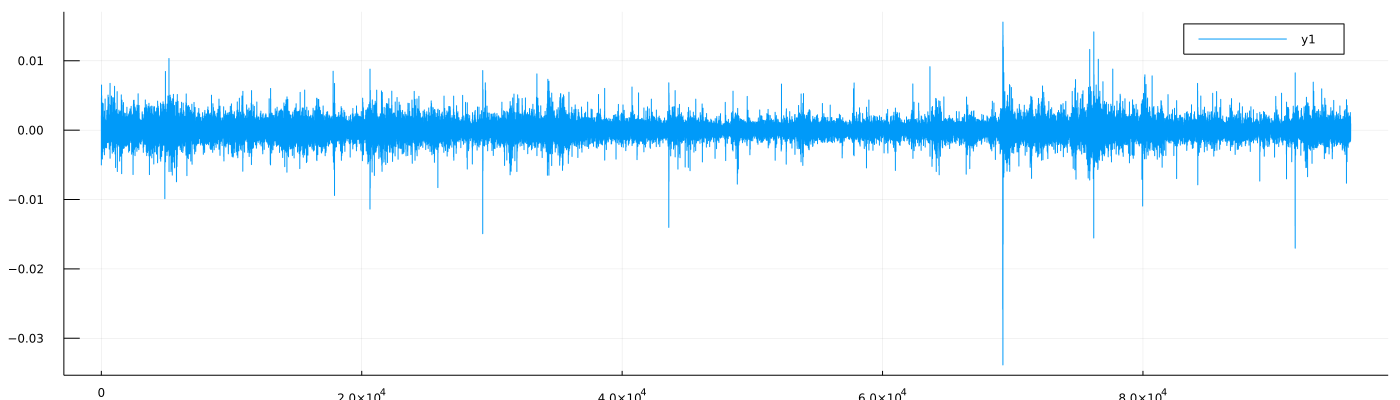

In [65]:
rets = [ (cc[i] - cc[i-1])/cc[i-1] * 1  for i in 2:length(cc)]
plot(rets, size=(1400,400))

In [66]:
# len = 10000
# subs=2
function window_slider(len; subs=1)
    log2len = Int(trunc(log2(len)))
    
    start_slider_box = Observable{Any}(dom"div"())
    
    log2_slider = slider(1:log2len, label = "2^n els/wnd", default = log2len/2)

    window_size = Interact.@map (2 ^ &log2_slider)
    window_start = Observable{Int64}(1)
#     window_end = Observable{Int64}()
    window_end = Interact.@map min(len, (&window_start) + &window_size )
    
#     map!((wst,wsz) -> min(len, (wst + 1) * wsz  -1), window_end, window_start, window_size)
    
    function make_startslider(wnd_size) 
        window_start[] = 1
#         window_end[] = min(len, wnd_size)
        window_start_slider = slider(1:Int(trunc(len/wnd_size*subs)); label="window#", default=1)
        window_start_slider[] = 1
        
        map!((wst) -> Int64(trunc((wst-1)*wnd_size/subs)+1) , window_start, window_start_slider)
#         map!(wst -> min(len, (wst + 1) * wnd_size  -1) , window_end, window_start_slider)
        dom"div"(window_start_slider)
    end
    
    map!(make_startslider, start_slider_box, window_size)
#     output = Interact.@map (&window_no * &window_size , (1 + &window_no) * &window_size - 1)
    output = Interact.@map [&window_start , &window_end]
    
    wdg = Widget(["log2_slider" => log2_slider, "start_slider_box" => start_slider_box, "window_start" => window_start,
            "window_size" => window_size, "window_end" => window_end], output = output)
    @layout! wdg vbox(:start_slider_box, :log2_slider) ## custom layout: by default things are stacked vertically
end


window_slider (generic function with 1 method)

In [82]:
# Interact.@map &window_start, &window_end

1

1

In [100]:
# ar_len = length(rets)
emasl = slider(1:500; label="ema", default=10)
cema = Interact.@map ema(cc,n=&emasl)
rets = Interact.@map (cc .- &cema)./&cema
rets = Interact.@map (&rets)[&emasl:length(&rets)]

wsl = window_slider(ar_len, subs=2^2)
wst = Interact.@map first(&wsl)
wed = Interact.@map last(&wsl)
plot_box = Observable{Any}(dom"div"())
rng = Interact.@map &wst: &wed
wrets = Interact.@map (&rets)[&rng]
lags = slider(1:500; label="lag", default=10)
lags[]=20
pacfs = Interact.@map length(&wrets) > &lags ? pacf(&wrets,[(1:&lags)...]) : []
wcc = Interact.@map cc[&rng]
crit_val = Interact.@map &wed > &wst ? 1.96/sqrt(&wed - &wst - &lags) : 0
# # put = Interact.@map ut[&rng]
# # wtt = Interact.@map tt[&rng]
# ui = dom"div"(lags, 
#         wsl, wsl.output,
# #     Interact.@map hbox(&wsl.output[]),
#     hbox(wrets,pacfs)
#     )

function draw_it_all(pacfs,wcc, crit_val)    
    f1 = scatter(pacfs, ylims=(-0.5,.5), markersize=2)
    hline!([crit_val, -crit_val])
    f2 = plot(wcc)
    plt = plot(f1,f2, size=(1200,500))
    dom"div"(plt) 
end

map!(draw_it_all, plot_box, pacfs,wcc, crit_val)
ui = dom"div"(hbox(lags,emasl), 
        plot_box,wsl
    )
wsl[:log2_slider][] = 9
lags[] = 15
ui



(div
  (div { style=Dict("display" => "flex", "flex-direction" => "row") }
    Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["lag"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 500, :default => 10, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :min => 1, :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Int64} with 3 listeners. Value:
15, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/johnsmith/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/johnsmith/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/johnsmith/.julia/packages/InteractBase/Zfu5P/src/../assets/all.js"), Asset("css", nothing, "/Users/johnsmith/.julia/packages/InteractBase/Zfu5P/src/../assets/style.css"), Asset("css", nothing, "/Users/johnsmith/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000010815cbc0, Task (runnable) @0x000000010815cbc0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",